In [1]:
# Copyright 2020 Bimghi Choi. All Rights Reserved.
# 예측 + 투자전략 시스템

# _*_ coding: utf-8 _*_

from tensorflow import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]='0, 1'

In [2]:
import util
import preprocess as prepro
import models
import learn
from learn import GenerateResult
import math
import datetime

In [3]:
#tf.keras.backend.set_floatx('float64')

In [4]:
import gc
gc.collect()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
#    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')    
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
    print(e)

In [5]:
file_name = '~/Data/kospi200f_809_0515.csv'
item_name = 'kospi200f_reinfo_809'
train_start = '2000-01-31'
train_end = '2019-01-02'
test_start = '2019-01-02'
test_end = '2020-05-15'

remove_columns = ['date', '종가']
target_column = '종가'
input_columns = []
target_type = 'rate'

model_name = 'ddaeryuble6'
channel = False

trans_day = 1

target_alpha = 100
future_day = 1
train_end_back = -1
n_timestep = 100
time_interval = 1
input_size = 809
n_unit = 500
batch_size = 20
learning_rate = 0.0005
epochs = 1000

alpha = 0.05
beta = 0.01
gamma = 0.1

comment = "예측 모델과 best share decision 모델(target = 현재까지의 수익률 합 + 다음 step의 최대 수익률*gamma) 의 reinforcing interaction, random time_interval, loss=mse"

checkpoint_path = model_name + "/pred"+str(future_day)+"_trans"+str(trans_day)+".ckpt"

In [6]:
dataframe = util.read_datafile(file_name)
df = dataframe.copy()
df['close'] = df[target_column] # 종가 column 추가, 기존 종가는 rate으로 변환 예정
a = []
b = []
#df = prepro.target_conversion(df, target_column, future_day, type=target_type)
for i in range(len(df[target_column]) -future_day):
    df.loc[i, target_column] = ((df.loc[i + future_day, target_column] - df.loc[i, target_column]) 
                                / df.loc[i, target_column]) * target_alpha     
    df.loc[i, '시가'] = df.loc[i + future_day + train_end_back + 1, '시가']
    a.append(max(df.loc[i  + future_day + train_end_back + 1:i + future_day + 1, '고가']))
    b.append(min(df.loc[i  + future_day + train_end_back + 1:i + future_day + 1, '저가']))
for i in range(len(df['종가']) - future_day):
    df.loc[i, '고가'] = a[i]
    df.loc[i, '저가'] = b[i]    

In [7]:
df.head(20)

,date,시가지수(포인트),고가지수(포인트),저가지수(포인트),종가지수(포인트),수익률(%),수익률 (1주)(%),수익률 (1개월)(%),수익률 (3개월)(%),수익률 (6개월)(%),...,주요상품선물_금(선물)($/ounce),주요상품선물_은(선물)($/ounce),주요상품선물_알루미늄(선물)($/ton),주요상품선물_옥수수(최근월물)(￠/bu),대두박(￠/bu),종가,시가,고가,저가,close
0,2000-01-31,-0.218225,-0.493106,-0.400439,-0.223565,0.212872,1.352924,-0.851790,-0.382658,-0.162615,...,-0.853010,0.974513,0.827681,0.373581,0.614542,-3.553512,120.85,121.70,115.35,119.60
1,2000-02-01,-0.213200,-0.230417,-0.373954,-0.595373,-0.407635,1.808646,-1.074203,-1.707405,-0.490731,...,-0.039689,0.193571,1.002058,0.594935,0.706918,2.687473,116.55,120.25,115.95,115.35
2,2000-02-02,-0.208520,-0.448886,-0.367787,-0.200398,0.696677,2.107257,-0.769928,-1.558400,0.074389,...,0.800355,0.031266,0.069626,0.430159,0.725768,0.675390,119.35,123.45,116.80,118.45
3,2000-02-03,-0.204125,-0.216603,-0.062403,-0.021445,0.366314,1.488978,-0.625155,-1.268930,-0.079967,...,1.515992,0.623370,0.378121,0.084769,0.352875,2.599581,120.40,123.60,119.75,119.25
4,2000-02-07,-0.200000,0.378008,0.426748,0.592789,0.949260,1.101574,1.281908,-1.288431,1.273730,...,3.856851,0.568635,-0.322023,0.518339,0.702038,-0.899060,122.90,124.10,120.95,122.35
5,2000-02-08,-0.196110,0.353748,0.677387,0.254527,-0.366454,1.138729,0.998930,-1.329397,0.942469,...,2.657684,1.222974,-0.720402,0.474125,0.440887,1.567010,122.40,125.05,120.40,121.25
6,2000-02-09,-0.192447,0.306497,0.819824,0.658684,0.641075,1.076862,1.233568,-1.637689,0.994675,...,3.026664,2.114708,-0.407511,0.622228,0.721716,-0.243605,120.85,125.05,119.85,123.15
7,2000-02-10,0.330923,0.617187,0.552762,0.366383,-0.311193,0.651653,0.275024,-1.607973,0.269679,...,3.316674,1.871659,-0.157431,0.985272,1.379493,-1.628002,123.60,124.75,115.25,122.85
8,2000-02-11,0.977388,0.576306,0.048738,-0.013448,-0.428351,0.326747,0.131530,-1.828185,0.546650,...,2.384344,0.988933,-0.154629,0.473525,0.907189,-4.013240,118.85,119.00,110.45,120.85
9,2000-02-14,-0.649462,-0.806483,-0.954529,-1.222378,-1.533955,-1.217328,-0.075927,-2.486079,0.140712,...,1.935983,0.085505,-0.246361,0.529501,0.923675,-4.439655,116.45,116.80,105.25,116.00


In [8]:
@tf.function
def loss_fn_model1(train_y, preds):
    
    #preds = tf.cast(preds, dtype=tf.float64)
    #train_y = tf.cast(train_y, dtype=tf.float64)
    rates = train_y / 100
    updown = tf.math.sign(train_y)
    profits = 1 + rates*tf.math.sign(preds)
    
    loss1 = keras.losses.MSE(train_y, preds)
    
    batches_float32 = tf.cast(tf.shape(train_y)[0], dtype=tf.float32)
    batches_int32 = tf.cast(tf.shape(train_y)[0], dtype=tf.int32)

    return_plus = 0.000000000
    return_minus = 0.000000000
    for i in range(batches_int32):
        if profits[i, -1, 0] - 1 > 0: return_plus += profits[i, -1, 0]-1      
        else: return_minus += 1-profits[i, -1, 0]    

    loss2 = (return_plus - return_minus)/batches_float32
    
    return loss1 - loss2


In [9]:
@tf.function
def loss_fn_model2(m1, m2, train_x, train_y):
    
    batches = train_y.shape[0]
    steps = train_y.shape[1]    
    
   
    train_y_close = tf.expand_dims(train_y[:, :, 3], 2)
    
    train_y_target = tf.expand_dims(train_y[:, :, 4], 2)
    rates = tf.cast(train_y_target / 100, dtype=tf.float64)      
    
   
    # 예측모델(model1)의 output
    preds = tf.cast(m1(train_x), dtype=tf.float64)
    
    # 수익률(%) 계싼
    profits = tf.sign(preds) * rates
    
    # 다음 step의 수익률
    #last_rates = tf.reshape(rates[:, -1, 0], [-1])
    
    # ccurrent step의 수익률
    #rates = tf.concat([tf.reshape(rates[:, :-1, 0], [batches, steps - 1, 1]), np.zeros((batches, 1, 1))], 1)
    
    # model2 current input 생성
    train_x_m2 = tf.concat([preds, rates], 2)
    y = tf.cast(m2(train_x_m2), dtype=tf.float64)
    
    # batch i에서 model2의 target = num * ( 1 + (p(t) - p(t-1)) / P(t-1)) * p(t-1) / p(t-n) + gamma * next_best_num
    targets = tf.reshape(y[:, :, 1], [-1, n_timestep, 1])*profits
    
    loss = -tf.reduce_mean(targets)*100
        
    return loss


In [10]:
def test(m1, m2, test_x, test_y):
    
    train_y_target = np.expand_dims(train_y[:, :, 4], axis=2)
    
    rates = tf.cast(test_y_target / 100, dtype=tf.float64)
    rates_ = tf.reshape(rates[:, :-1, 0], [rates.shape[0], rates.shape[1] -1, 1])
    new_rates = tf.concat([rates_, np.zeros((rates.shape[0], 1, 1))], 1)
    
    preds = tf.cast(m1(test_x), dtype=tf.float64)
    
    # model2 input 생성
    test_x_m2 = tf.concat([preds, new_rates], 2)
    y = tf.cast(m2(test_x_m2), dtype=tf.float64)

    return y[:, -1, 1]

In [11]:
@tf.function
def gradient1(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model1.trainable_variables)
@tf.function
def gradient2(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model2.trainable_variables)

In [12]:
#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
model1 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#model2 = models.LSTM_sigm(n_timestep,2,10,regularizers_alpha=0.01,drop_rate=0)

model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(n_timestep, 2)),
    tf.keras.layers.LSTM(100, return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'),
])
model2.summary()

    #cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #    checkpoint_path, verbose=1, save_weights_only=True,
        # 다섯 번째 에포크마다 가중치를 저장합니다
    #    save_freq=5)

model1.compile(optimizer='adam',
              loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])
#model1.save_weights(checkpoint_path)            

#    model2 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#    model2.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])            

#modle_name = model_name + "tanh"            
#model2.save_weights("modle2_"+ checkpoint_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 100)          41200     
_________________________________________________________________
dense_1 (Dense)              (None, 100, 64)           6464      
_________________________________________________________________
dense_2 (Dense)              (None, 100, 2)            130       
Total params: 47,794
Trainable params: 47,794
Non-trainable params: 0
_________________________________________________________________


In [13]:
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

while True:

    gc.collect()
    
    train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                           current_train_start, current_train_end,
                                                           current_test_start, current_test_end,
                                                           future_day, n_timestep, time_interval)


    train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
    
    # randomly selected  step size
    #drop_idx = np.random.randint(int(train_y.shape[1]/2))
    #train_x[:, :drop_idx, :] = 0
    #train_y[:, :drop_idx, :] = 0    
    
    train_x = train_x[:train_end_back]
    train_y = train_y[:train_end_back]
    
    test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)
    test_y_target = np.expand_dims(test_y[:, :, 4], axis=2)    
    
    # train, validation set 분리하여 train1은 예측모델로 train2는 손절값 학습 모델로 사용
    #train1_x, train2_x, train1_y, train2_y = train_test_split(train_x, train_y, test_size=0.5)    
    
    updown = np.sign(test_y[:, -1, 4]).reshape((-1))
    
    # random batch_size
    #batch_size = np.random.randint(10, 50)    

    # model1 training
    #train1_y_target = np.expand_dims(train1_y[:, :, 4], axis=2)
    #early_stopping1 = tf.keras.callbacks.EarlyStopping(patience=2, verbose=1)
    #model1.load_weights(checkpoint_path)
    #model1.fit(train1_x, train1_y_target, batch_size=batch_size, epochs=3, callbacks=[early_stopping1], validation_data=(test_x, test_y_target))
    #model1.save_weights(checkpoint_path)
    
    # model2 training
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)    
    early_stopping2 = learn.EarlyStopping(patience=2, verbose=1)
    iter = epochs
    basic_epochs = tf.cast(epochs / 5, dtype=tf.int32)
    for iteration in range(iter):
        batch_input, batch_output = learn.next_random_batch(train_x, train_y, batch_size)

        gradients1 = gradient1(model1, model2, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
        gradients2 = gradient2(model1, model2, batch_input, batch_output)        
        optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))

        if iteration % 100 == 0:

            # model2의 test loss
            loss2 = loss_fn_model2(model1, model2, test_x, test_y)
            print('model2 loss =', loss2)   

        if iteration > iter / 2 and early_stopping2.validate(loss2)==True:
            break    

    if iter > basic_epochs: iter -= basic_epochs
    if iter < basic_epochs: iter = basic_epochs

    print('test dates ' + current_test_start + "~" + current_test_end)

    # prediction1 accuracy
    prediction1 = model1.predict(test_x)[:, -1, 0].reshape(-1)
    temp = tf.math.multiply(updown, prediction1)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('prediction1 accuracy = ', accu)

    # reinforced prediction2
    prediction2 = test(model1, model2, test_x, test_y)    
    print('optimal shares = ', prediction2)

    test_prediction1.append(prediction1)
    test_prediction2.append(prediction2)

    # escape from while
    if current_test_end == test_end:
     break

    #train, start dates shift
    current_train_end = df.loc[prepro.date_to_index(df, current_train_end) + trans_day, 'date']
    current_train_start = df.loc[prepro.date_to_index(df, current_train_end) - 1000, 'date']
    current_test_start = df.loc[prepro.date_to_index(df, current_test_start) + trans_day, 'date']
    if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < trans_day:
        current_test_end = test_end
    else:
        current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + trans_day, 'date']


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

model2 loss = tf

model2 loss = tf.Tensor(-0.44140194441552066, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4414028815039557, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4412730882331978, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-01-14~2019-01-14
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.99999976], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.42967494742542306, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.42967151387740654, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4281181096745479, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.06837700244503762, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.05437876651351174, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2759179591814063, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.43041862330051434, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.43089831474688045, shape=(), dtype=

model2 loss = tf.Tensor(-0.43683618059932067, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.43205216203928404, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-01-28~2019-01-28
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.99452364], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.44140003734258654, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4343851388332584, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.40446620454445625, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4326664848251091, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4265292391040116, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.3327118482409527, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.3747955016687687, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.380807512966573, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.39453441480214213, shape=(), dtype=f

model2 loss = tf.Tensor(-0.4124295630690225, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4124300199270104, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4124300305663846, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4124300358624002, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4124300395055203, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4124300350406389, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.41826083341800047, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4246938773595387, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4246948631020543, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4246951948376914, shape=(), dtype=float64)
test dates 2019-02-15~2019-02-15
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.99859804], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.42469599377727046, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.42469634900519965, shape=(), dtype=

model2 loss = tf.Tensor(-0.41225684611409014, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.41225684611341873, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4122568461171825, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.41225684612136454, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.412256846109767, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4122568461077496, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-03-04~2019-03-04
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.4016896770201381, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4016894100247925, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.40168569780416946, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.40168770190646835, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.4016859374481464, shape=(), dtype=float64)


model2 loss = tf.Tensor(-0.33527219298051336, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-03-18~2019-03-18
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.95812547], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.33527219488052246, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.33527219479734655, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.33527219475558284, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.33527219480062487, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.3352721948000476, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.33527219402171166, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.3352721948436136, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.3352721948016775, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-03-19~2019-03-19
prediction1 accuracy =  tf.Te

model2 loss = tf.Tensor(-0.31499947897473224, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.31499947902327996, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.3149994788629862, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.31499947915384346, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.31499947920952176, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.3149994791868188, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.31499947922274457, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.3149994791120855, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-04-02~2019-04-02
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([3.30812e-16], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.3044493580766871, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.3044493612005302, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.30444936169292947, shape=(), dtyp

model2 loss = tf.Tensor(-0.27679951083898136, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.24478141224861444, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2523327689702331, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.26574459561472347, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2657446273259628, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.26631912371710637, shape=(), dtype=float64)
test dates 2019-04-16~2019-04-16
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([9.82723662e-08], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.2663191236444052, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2663191238073127, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.26172548423134095, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.26172548423134095, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.26172548423134095, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.26172548423134095, shape=(

model2 loss = tf.Tensor(-0.2390502792926298, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.23905027929263023, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.23905027929262626, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.23905027929262043, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-04-30~2019-04-30
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([7.7255578e-35], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.23905027929255326, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.23905027929255027, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.23905027929254438, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.23905027929254558, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2390502792925447, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2390502792925398, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.23905027929254138, shape=(), 

model2 loss = tf.Tensor(-0.19709822700764587, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.19709822700765095, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.19709822700765717, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.19709822700766208, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.19709822700766672, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.19709822700767185, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.19709822700767937, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.19709822700768265, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.19709822700768667, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1970982270076895, shape=(), dtype=float64)
test dates 2019-05-17~2019-05-17
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.19709822700703902, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.19709822700703833, shape=(), dtype=

model2 loss = tf.Tensor(-0.15359391161911243, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.15359391161911243, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.15359391161911243, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1535939116191124, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.15359391161911237, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.15359391161911237, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.15359391161911234, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-06-03~2019-06-03
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1.08764037e-31], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.14945847160336653, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.14945847160460377, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.14945847161282955, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.14945847162265624, shape=(

prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1.04607745e-08], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.16343044216854857, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.16343044216855185, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.16343044216836872, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.16343044216824731, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.163430442168065, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.16343044216791391, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.16343044216785002, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-06-18~2019-06-18
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([9.28091003e-28], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.16343044216671893, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.16343044216670585, shape=(), dty

model2 loss = tf.Tensor(-0.17062577423145117, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1706256916697546, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.17062601362210442, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.17062624929740677, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.17062721038254614, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1706272226259095, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.17062716484216436, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-07-02~2019-07-02
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1.01575307e-27], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.17060914057967425, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.17060914057967425, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.17060914057967425, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.17060914057967425, shape=()

model2 loss = tf.Tensor(-0.12454160425484165, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.12454160425545763, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.12454160425579572, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.12454160425524406, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-07-16~2019-07-16
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.1335309137493549, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1335655850876969, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1335786263816432, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.13361430384182363, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.13360364196631372, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.13361726446379257, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.13375166297493785, shape=(), dtype=float

model2 loss = tf.Tensor(-0.09720675700770291, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.09720675700770291, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.09720675700770291, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.09720675700770291, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0972067570077029, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0972067570077029, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0972067570077029, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0972067570077029, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.09720675700770291, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.09720675700770288, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-07-30~2019-07-30
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.09275020996781853, shape=(), dtype=float6

model2 loss = tf.Tensor(-0.0835899962326171, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0835899962326171, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0835899962326171, shape=(), dtype=float64)
test dates 2019-08-12~2019-08-12
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.08358999623261712, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.08358999623261712, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.08358999623261712, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.08358999623261712, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.08358999623261712, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.08358999623261712, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.08358999623261712, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.08358999623261712, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.08358999623261712, shape=(), dtype=fl

model2 loss = tf.Tensor(-0.0673648411060538, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0673648411060538, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0673648411060538, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0673648411060538, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0673648411060538, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0673648411060538, shape=(), dtype=float64)
test dates 2019-08-27~2019-08-27
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.0673648411060538, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0673648411060538, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0673648411060538, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0673648411060538, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0673648411060538, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0673648411060538, shape=(), dtype=float64)
mo

model2 loss = tf.Tensor(-0.07017335597258219, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.07017335597258294, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.07017335597258366, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.07017335597258671, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.07017335597259038, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.07017335597259046, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.07017335597259128, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.07017335597259282, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.07017335597259479, shape=(), dtype=float64)
test dates 2019-09-10~2019-09-10
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([4.5905146e-12], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.04301740221120942, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.043017402211209935, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.04301740221120962, sha

model2 loss = tf.Tensor(0.004766847873032229, shape=(), dtype=float64)
test dates 2019-09-25~2019-09-25
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(0.006799368196080615, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.006799368195971659, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0067993681957465215, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.006799368195666806, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.006799368195438497, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.006799368195252544, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.006799368195103826, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.006799368194946028, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0067993681947453736, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.0067993681945849125, shape=(), dtype=float64)
test dates 2019-09-26~2019-09-26
prediction1 accuracy =  t

model2 loss = tf.Tensor(-0.02787861694163514, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.02787861569502569, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-10-11~2019-10-11
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.025943720373889034, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.025946262597929214, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.025948298061364596, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.025950813176654, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.025950907076752412, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.025953762147312095, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.02595632490478903, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.025959773599312362, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.025963827568794347, shape=(), dty

model2 loss = tf.Tensor(-0.1503589402511241, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1503589402511241, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1503589402511241, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1503589402511241, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1503589402511241, shape=(), dtype=float64)
test dates 2019-10-25~2019-10-25
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.1472563612323147, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1472563612323147, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1472563612323147, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1472563612323147, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1472563612323147, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1472563612323147, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1472563612323147, shape=(), dtype=float64)
mo

model2 loss = tf.Tensor(-0.17084627780520903, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1707521175429403, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1706432510592102, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1704104813983133, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.17035698920913214, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.170235661427862, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-11-08~2019-11-08
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.58217973], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.17850579305709977, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1784787950410327, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.17690049609647263, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.17690049609645903, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.17690049609647268, shape=(), dtype=

model2 loss = tf.Tensor(-0.2141270803784223, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2248961563918503, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.22180289005028225, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.22051004505430039, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2200107228977221, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.21976409593076224, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-11-22~2019-11-22
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.97007048], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.2084308512080995, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.21391394612627707, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2139139480393024, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.21391394803930222, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.21391394803930192, shape=(), dtype

model2 loss = tf.Tensor(-0.20039717743585422, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20039717743585211, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20039717743586344, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20039717743587965, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20039717743586624, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20039717743587515, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2003971774358681, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-12-09~2019-12-09
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.2003971774358692, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20039717743587687, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2003971774358815, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.200397177435892, shape=(), dtype=float64

model2 loss = tf.Tensor(-0.13705723821747565, shape=(), dtype=float64)
test dates 2019-12-20~2019-12-20
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.1216203827492096, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1216203827492096, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1216203827492096, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1216203827492096, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1216203827492096, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1216203827492096, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1216203827492096, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1216203827492096, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1216203827492096, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.1216203827492096, shape=(), dtype=float64)
test dates 2019-12-23~2019-12-23
prediction1 accuracy =  tf.Tensor(1.0,

model2 loss = tf.Tensor(-0.13236380125340064, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.13236380125340064, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.13236380125340064, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.13236380125340064, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.13236380125340064, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.13236380125340064, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.13236380125340064, shape=(), dtype=float64)
test dates 2020-01-08~2020-01-08
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.11554396424975936, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.11554396424975936, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.11554396424975936, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.11554396424975936, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.11554396424975936, shape=(), dtype

model2 loss = tf.Tensor(-0.09329661844598676, shape=(), dtype=float64)
test dates 2020-01-21~2020-01-21
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.06261092833338987, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.06261092833338987, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.06261092833338987, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0626109302196128, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.06261092833338987, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0626109302196128, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.0626109302196128, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.06261092833338987, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-01-22~2020-01-22
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.99999678],

step :  3
Training process is stopped early....
test dates 2020-02-06~2020-02-06
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.262970512590321, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.26297051579243913, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2629705159435029, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.26297051689941, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2629705200967115, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.26297052786630126, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2629705563877412, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.26297059894940056, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.26297068268477913, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.26297070902605707, shape=(), dtype=float64)
test dates 2020-02-07~2020-02-07
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=floa

test dates 2020-02-20~2020-02-20
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.2552758687587933, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.255275868758795, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.25527586875879765, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2552758687588012, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.25527586875880487, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2552758687588097, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2552758687588138, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.25527586875881847, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2552758687588231, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.25527586875882796, shape=(), dtype=float64)
test dates 2020-02-21~2020-02-21
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([2.40360303e-1

model2 loss = tf.Tensor(-0.20680527188794057, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20680527188795603, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20680527188797496, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20680527188799763, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20680527188801598, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20680527188803424, shape=(), dtype=float64)
test dates 2020-03-05~2020-03-05
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.2084279752084512, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20843564489931224, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.2084514628378672, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20847430405843032, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20849892811934936, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.20852572899356872, shape=(), dtype=f

model2 loss = tf.Tensor(-0.7436783977608319, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.7436783977606751, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.7436783977605081, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.7436783977602954, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-03-19~2020-03-19
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([0.86254847], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.7425821068678387, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.7425821068675467, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.7425821068671086, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.7425821068664851, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.7425821068656444, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.7425821068650955, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.7425821068645215, shape=(), dtype=float

model2 loss = tf.Tensor(-0.6718362802224132, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6718362802224132, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6718362802224132, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6718362802224132, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6718362802224132, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6718362802224132, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6718362802224132, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6718362802224132, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6718362802224132, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6718362802224132, shape=(), dtype=float64)
test dates 2020-04-03~2020-04-03
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1.31762759e-23], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.6626424976976988, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6626382221071143, shape=(), dtype

test dates 2020-04-17~2020-04-17
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.5325818471833013, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.5325818471833013, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.5325818471833013, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.5325818471833013, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.5325818471833013, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.5325818471833013, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.5325818471833013, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.5325818471833013, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.5325818471833013, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.5325818471833013, shape=(), dtype=float64)
test dates 2020-04-20~2020-04-20
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1.], shape=(1,),

model2 loss = tf.Tensor(-0.6317784643914406, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.631778464396083, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.631778464394674, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6317784643996782, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6317784643997811, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6317784644021015, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6317784643992741, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-05-07~2020-05-07
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
optimal shares =  tf.Tensor([1.], shape=(1,), dtype=float64)
model2 loss = tf.Tensor(-0.6205380778894766, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6205380778882166, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6205380778885234, shape=(), dtype=float64)
model2 loss = tf.Tensor(-0.6205380778927342, shape=(), dtype=float64)
model2

In [14]:
t1 = np.concatenate(test_prediction1)
t2 = np.concatenate(test_prediction2)

In [15]:
#t2

In [16]:
#test_prediction = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
#train_prediction = learn.predict_batch_test(model1, train_x[:batch_size], len(train_x[:batch_size]))

# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴
test_dates, test_base_prices, train_dates, train_base_prices = prepro.get_test_dates_prices(dataframe, test_start, test_end,
                                                      train_start, train_end, n_timestep, time_interval, future_day, target_column)

# 전체 test_oouput 생성
_, test_data = prepro.get_train_test_data(df, target_column, remove_columns,
                                                   train_start, train_end,
                                                   test_start, test_end,
                                                   future_day, n_timestep, time_interval)
_, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

In [17]:
# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴 - 종가를 test base price로 하는 경우
result = GenerateResult(t1, t2, test_y[:, -1, 4].reshape(-1), test_dates, n_timestep, future_day, trans_day)

#result.extract_last_output()
result.convert_price(test_base_prices,conversion_type=target_type)

# 손익 계산을 위한 데이터 정리
test_start_index = prepro.date_to_index(df, test_start)
test_end_index = prepro.date_to_index(df, test_end)
test_open_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '시가']))
test_high_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '고가']))
test_low_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '저가']))

# 예측 손익 계산
profits = np.zeros(len(test_dates))
for i in range(len(test_dates)):
    if result.test_predict_price[i]-test_open_prices[i] > 0:
        profits[i] = result.test_output_price[i] - test_open_prices[i]
    else:
        profits[i] = test_open_prices[i] - result.test_output_price[i]

# 투자 비율 반영 손익 계산
profits2 = np.zeros(len(test_dates))
for i in range(len(test_dates)):
    if result.test_predict_price[i]-test_open_prices[i] > 0:
        profits2[i] = (result.test_output_price[i] - test_open_prices[i])*t2[i]
    else:
        profits2[i] = (test_open_prices[i] - result.test_output_price[i])*t2[i]

In [18]:
# 종가 대비 에측 확률 계싼
updown = np.sign(test_y[:, -1, 4]).reshape((-1))
temp = tf.math.multiply(updown, t1.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('종가 대비 accuracy = ', accu)

# 시가 대비 예측 확률
cnt  = 0
for i in range(len(profits)):
    if profits2[i] > 0:
        cnt += 1
accu = cnt / len(profits2)        
print('시가 대비 accuracy = ', accu)

종가 대비 accuracy =  tf.Tensor(0.4599406528189911, shape=(), dtype=float64)
시가 대비 accuracy =  0.36795252225519287


info : ddaeryuble6_kospi200f_reinfo_809_100_1_1_0.46
MSE : 3573.914 , Accuracy : 0.46
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/ddaeryuble6_kospi200f_reinfo_809_100_1_1_0.46/assets


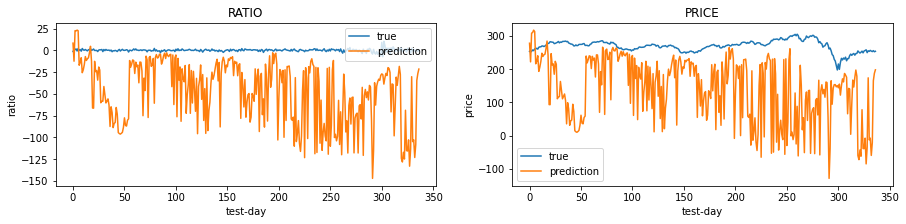

In [19]:
result.evaluation()
result.table(test_open_prices, test_high_prices, test_low_prices, profits, profits2)
result.save_result(model_name,item_name,n_unit,target_type,batch_size,n_timestep,time_interval,epochs,str(alpha),comment)
result.save_visualization()
result.save_model(model2)

In [20]:
"""
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)


gc.collect()

train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                       current_train_start, current_train_end,
                                                       current_test_start, current_test_end,
                                                       future_day, n_timestep, time_interval)

# input_size, columns reset
input_size = len(df.columns) - len(remove_columns)
input_columns = df.columns.copy()

train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

#model.compile(optimizer='adam',
#          loss=loss_fn)
#          #callbacks=[cp-callback]
#          #metrics=['accuracy'])

# the firs training dataset
train_x = train_x[:-future_day]
train_y = train_y[:-future_day]    

#global_step = tf.train.get_or_create_global_step()
global_step = tf.Variable(0, trainable=False)
#lr_decay = tf.train.exponential_decay(learning_rate, global_step,
#                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

updown = np.sign(test_y[:, -1, 0]).reshape((-1))    
epochs = len(train_y)
for iteration in range(399):
    batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)

    #noise = 2*np.random.randn(batch_size,n_timestep,1)
    #batch_output = batch_output+noise
    #batch_input = encoder(train_input[idx])
    gradients1 = gradient1(model1, model2, batch_input, batch_output)
    optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
    
    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = targets / 100
    preds = tf.reshape(model1(train_x, training=False)[:, -1, 0], [-1])
    
    n = len(targets)    
    returns = [1.0]
    losses = []
    for i in range(n - 1):
       
        # average_return, std of returns, remaining days, preds[0] 
        state = []
        
        random_rates = []
        for k in range(i+1):
            random_rates.append(rates[k])
        # 실재 수익률을 기반으로 random 수익률 생성, 예측에 의한 porfits 생성 
        for k in range(i+1, n):
            random_rates.append(tf.random.normal((), mean=targets[k] / 100, stddev=0.1, dtype=tf.float64))
        profits = tf.convert_to_tensor(random_rates, dtype=tf.float64)*tf.cast(preds, dtype=tf.float64) + 1
        
        # 현재까지의 예측에 의한 수익률 기하평균 구하기
        returns_past = []
        for k in range(i+1):
            returns_past.append(profits[k])
        avg_return = tf.cast(tf.math.reduce_prod(returns_past)**(1/(i+1)), dtype=tf.float64)
        
        state.append(avg_return)
        state.append(tf.math.reduce_std(returns))
        state.append((n - i) / n)
        state.append(preds[i])
        state = np.array(state).reshape((1, 4))
     
        # 목표일까지의 기대 기하 평균 수익률 구하기 
        returns_future = []
        for j in range(i+1, n):
            returns_future.append(profits[j])
        avg_return_future = tf.math.reduce_prod(returns_future)**(1/(n-i-1))

        # 예측 기하 평균 수익률과 기대 기하 평균 수익률의 MSE
        value = tf.cast(model2(state, training=True)[0, 0], dtype=tf.float64)
        losses.append((value - avg_return_future)**2)
        if n == 3: break
    print("losses", losses)
    print("value", value)    
    with tf.GradientTape() as tape:
        gradients2 = tape.gradient(tf.math.reduce_sum(losses), model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
    

    
    if iteration % 100 == 0:
        #test_MSE = model.evaluate(test_x, test_y)
        prediction = model1.predict(test_x)
        prediction_MSE = sum((updown - np.sign(prediction[:, -1, 0]).reshape(-1))**2)/len(test_y)
        print('prediction_MSE =', prediction_MSE)

    if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
        break
epochs -= epochs / 5
if epochs <= 0: epochs = 100
"""

'\ncurrent_train_start = df.loc[prepro.date_to_index(df, train_start), \'date\']\ncurrent_train_end = df.loc[prepro.date_to_index(df, train_end), \'date\']\ncurrent_test_start = df.loc[prepro.date_to_index(df, test_start), \'date\']\ncurrent_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, \'date\']\n\n\n#  각 transfer 구간의 예측값들을 합치기 위하여\ntest_prediction1 = []\ntest_prediction2 = []\ntest_target = []\n\n# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)\nearly_stopping = learn.EarlyStopping(patience=2, verbose=1)\n\n\ngc.collect()\n\ntrain_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, \n                                                       current_train_start, current_train_end,\n                                                       current_test_start, current_test_end,\n                                                       future_day, n_timestep, time_interval)\n\n# input_size, columns reset\ninput_size 